With a very small dataset, lots and lots of different engineered features, vastly different CV and LB scores, and high inconsisency of LB scores with just slight changes in seed, this competition is overripe for a major shakupe. In this kernel we'll take a look at adveserial validation, and what it may portend about the shakeup.

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn import model_selection, preprocessing, metrics
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import shap
import os
print(os.listdir("../input"))

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Any results you write to the current directory are saved as output.

['andrews-features-only', 'LANL-Earthquake-Prediction']


For the features I'll use a good set of engineered features. Feature angineering was done by Andrew, and I had just created a separate kernel where they can be looked at in their own right and saved:

https://www.kaggle.com/tunguz/andrews-features-only

In [2]:
train = pd.read_csv('../input/andrews-features-only/X_tr.csv')
test = pd.read_csv('../input/andrews-features-only/X_test.csv')

In [3]:
train.shape

(4194, 138)

In [4]:
test.shape

(2624, 138)

In [5]:
features = train.columns
train['target'] = 0
test['target'] = 1

In [6]:
train_test = pd.concat([train, test], axis =0)

target = train_test['target'].values

In [7]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 5,
         'learning_rate': 0.006,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 27,
         "metric": 'auc',
         "verbosity": -1}

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train_test))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_test.values, target)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_test.iloc[trn_idx][features], label=target[trn_idx])
    val_data = lgb.Dataset(train_test.iloc[val_idx][features], label=target[val_idx])

    num_round = 30000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1400)
    oof[val_idx] = clf.predict(train_test.iloc[val_idx][features], num_iteration=clf.best_iteration)

fold n°0
Training until validation scores don't improve for 1400 rounds.
[1000]	training's auc: 0.940125	valid_1's auc: 0.832808
Early stopping, best iteration is:
[35]	training's auc: 0.881867	valid_1's auc: 0.83726
fold n°1
Training until validation scores don't improve for 1400 rounds.
[1000]	training's auc: 0.938003	valid_1's auc: 0.846147
[2000]	training's auc: 0.980072	valid_1's auc: 0.844377
Early stopping, best iteration is:
[827]	training's auc: 0.927985	valid_1's auc: 0.846948
fold n°2
Training until validation scores don't improve for 1400 rounds.
[1000]	training's auc: 0.935839	valid_1's auc: 0.854196
[2000]	training's auc: 0.978081	valid_1's auc: 0.856872
[3000]	training's auc: 0.995682	valid_1's auc: 0.857299
[4000]	training's auc: 0.999605	valid_1's auc: 0.857354
Early stopping, best iteration is:
[3375]	training's auc: 0.998053	valid_1's auc: 0.857614
fold n°3
Training until validation scores don't improve for 1400 rounds.
[1000]	training's auc: 0.936003	valid_1's auc: 

Whoa, that's a pretty significant AUC! At AUC of 0.85 there is a very significant difference between the train and test sets, and a very very good chance of a major shakeup ...

Let's look now at the top 20 "adversarial" features.

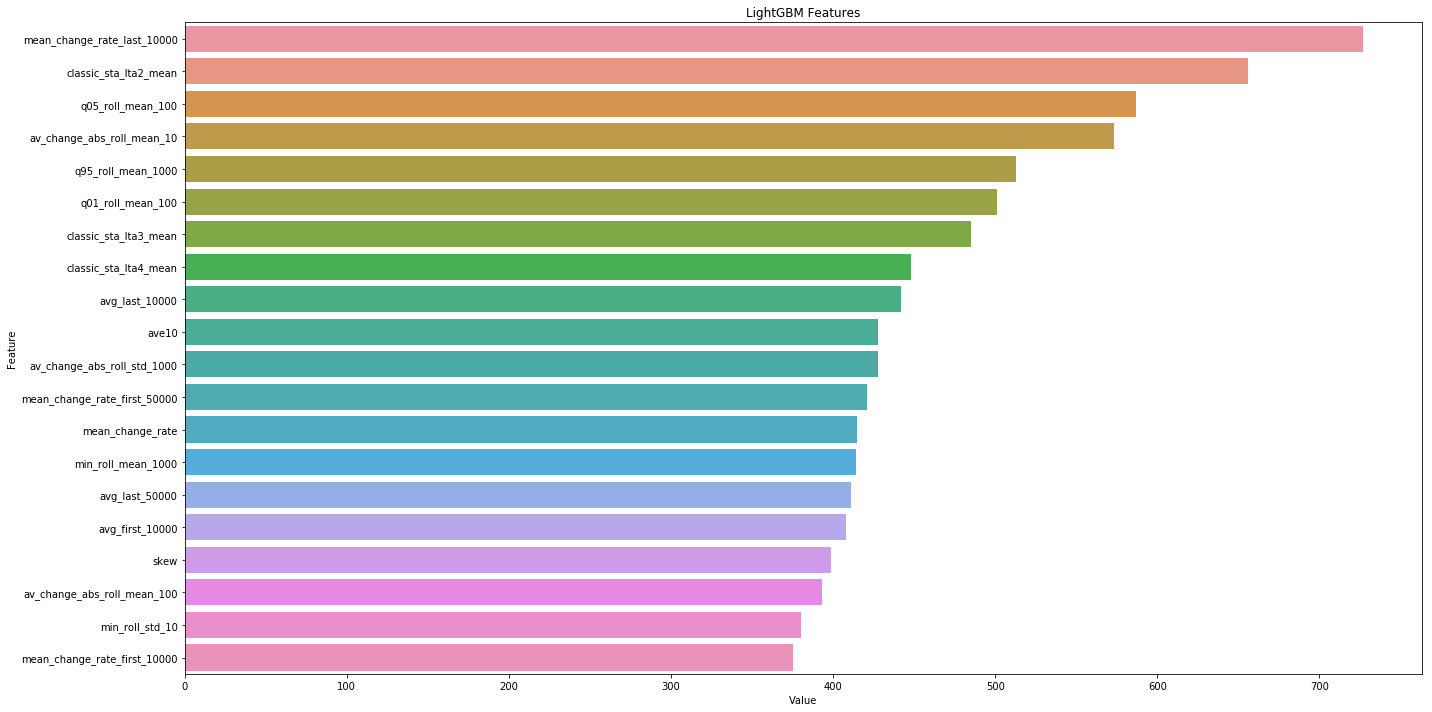

<Figure size 432x288 with 0 Axes>

In [27]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

(138,)